In [35]:
import sys
import os


from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqIO import FastaIO

import networkx as nx
from networkx.drawing.nx_agraph import write_dot
from networkx.drawing.nx_agraph import read_dot

import edlib

from IPython.display import Image, display

PATH = "_INSERT_"
DATA_PATH = "_INSERT_"
threads = 1

In [36]:
######### Run HORmon on centromeres from cens (saves into PaperResults folder) ##############

# cens = ["X"]
# for c in cens:
#     os.system(" ".join(["python3", os.path.join(PATH, "centromere-architect", "src", "HORmon.py"),\
#                        "--seq", os.path.join(DATA_PATH, "CentromereFasta", "cen" + c + ".fa"), \
#                        "--mon", os.path.join(DATA_PATH, "CAMonomers", "cen" + c + "_monomers.fa"), \
#                        "-t", str(threads), "-o", os.path.join(PATH, "PaperResults", "cen" + c)] ))

In [37]:
########### Rename final monomers to CA names in graphs and decs (for paper purposes only) ################

def edist(lst):
    if len(str(lst[0])) == 0:
        return 100500
    if len(str(lst[1])) == 0:
        return 100500
    result = edlib.align(str(lst[0]), str(lst[1]), mode="NW")
    if result["editDistance"] == -1:
        return 100500
    return result["editDistance"]

def load_fasta(filename):
    records = list(SeqIO.parse(filename, "fasta"))
    for i in range(len(records)):
        records[i] = records[i].upper()
    return records

def read_monomer_graph(filename):
    G = nx.DiGraph(read_dot(filename))
    return G

def draw_monomer_graph(G, outdir):
    write_dot(G, os.path.join(outdir, "graph_paper.dot"))
    try:
        check_call(['dot', '-Tpng', os.path.join(outdir, "graph_paper.dot"), '-o', os.path.join(outdir, "graph_paper.png")])
    except Exception:
        return

def get_manual_mapping(cen, mon_lst):
    manual_mons = load_fasta(os.path.join(DATA_PATH, "T2TMonomers", "cen" + c + "_monomers.fa"))
    res = {}
    for m in mon_lst:
        best_m, best_ed = None, 1000500
        for mm in manual_mons:
            ed = edist([m.seq, mm.seq])
            if ed < best_ed:
                best_m, best_ed = mm.id, ed
        res[m.id] = best_m
    return res

def get_ca_mapping(cen, mon_lst):
    ca_mons = load_fasta(os.path.join(DATA_PATH, "CAMonomers", "cen" + c + "_monomers.fa"))
    res = {}
    for m in mon_lst:
        best_m, best_ed = None, 1000500
        for mm in ca_mons:
            ed = edist([m.seq, mm.seq])
            if ed < best_ed:
                best_m, best_ed = mm.id, ed
        res[m.id] = best_m
    return res

def build_new_names_from_final_mons(mon_lst, labels_mp, cen):
    res = {}
    manual_mp = get_manual_mapping(cen, mon_lst)
    #print(manual_mp)
    for m in mon_lst:
        print(m.description)
        if m.id in labels_mp:
            res[m.id] = m.description.split(" ")[1]+ "(" + manual_mp[m.id] + ")[" + labels_mp[m.id].split('[')[1][:-1]
    return res

def build_new_names_from_ca_mons(mon_lst, labels_mp, cen):
    res = {}
    manual_mp = get_manual_mapping(cen, mon_lst)
    for m in mon_lst:
        print(m.description)
        if m.id in labels_mp:
            res[m.id] = m.id+ "(" + manual_mp[m.id] + ")[" + labels_mp[m.id].split('[')[1]
    return res

def update_dec(filename, mapping):
    with open(filename, "r") as fin:
        with open(filename[:-len(".tsv")] + "_paper.tsv", "w") as fout:
            for ln in fin.readlines():
                mon = ln.split("\t")[1]
                rev = ""
                if mon.endswith("'"):
                    rev = "'"
                    mon = mon[:-1]
                new_ln = "\t".join([ln.split("\t")[0], mapping[mon].split("(")[0] + rev] + ln.split("\t")[2:])
                fout.write(new_ln)

def convert2old(mon_str, mapping):
    res = []
    for m in mon_str.split(","):
        res.append(mapping[m].split("(")[0])
    return ",".join(res)

def update_chor(filename, mapping):
    with open(filename, "r") as fin:
        with open(filename[:-len(".tsv")] + "_paper.tsv", "w") as fout:
            for ln in fin.readlines():
                lst = ln.strip().split("\t")
                fout.write(lst[0] + "\t" + convert2old(lst[1], mapping) + "\n")
                print(lst[0] + "\t" + convert2old(lst[1], mapping) + "\n")

for c in cens:
    final_mon_lst = load_fasta(os.path.join(PATH, "PaperResults", "cen" + c, "mn.fa"))
    FG = read_monomer_graph(os.path.join(PATH, "PaperResults", "cen" + c, "graph.dot"))
    FSG = read_monomer_graph(os.path.join(PATH, "PaperResults", "cen" + c, "final_simplified_graph", "graph.dot"))
    labels = FG.nodes.data("label")
    labels_mp = {}
    for l in labels:
        labels_mp[l[0]] = l[1]
    mapping = build_new_names_from_final_mons(final_mon_lst, labels_mp, c)
    nx.set_node_attributes(FG, mapping, name="label")
    draw_monomer_graph(FG, os.path.join(PATH, "PaperResults", "cen" + c))
    nx.set_node_attributes(FSG, mapping, name="label")
    draw_monomer_graph(FSG, os.path.join(PATH, "PaperResults", "cen" + c, "final_simplified_graph") )
    
    update_dec(os.path.join(PATH, "PaperResults", "cen" + c, "final_decomposition.tsv"), mapping)
    update_chor(os.path.join(PATH, "PaperResults", "cen" + c, "HORs.tsv"), mapping)
    
    ms_mon_lst = load_fasta(os.path.join(PATH, "PaperResults", "cen" + c, "merge_split", "mn.fa"))
    G = read_monomer_graph(os.path.join(PATH, "PaperResults", "cen" + c, "merge_split", "graph.dot"))
    SG = read_monomer_graph(os.path.join(PATH, "PaperResults", "cen" + c, "simplified_graph", "graph.dot"))
    labels = G.nodes.data("label")
    labels_mp = {}
    for l in labels:
        labels_mp[l[0]] = l[1]
    mapping = build_new_names_from_ca_mons(ms_mon_lst, labels_mp, c)
    nx.set_node_attributes(G, mapping, name="label")
    draw_monomer_graph(G, os.path.join(PATH, "PaperResults", "cen" + c, "simplified_graph"))
    nx.set_node_attributes(SG, mapping, name="label")
    draw_monomer_graph(SG, os.path.join(PATH, "PaperResults", "cen" + c, "merge_split") )
    

D AX S3CXH1L.1
E BX S3CXH1L.2
F CX S3CXH1L.3
G DX S3CXH1L.4
H EX S3CXH1L.5
I FX S3CXH1L.6
J GX S3CXH1L.7
K HX S3CXH1L.8
L IX S3CXH1L.9
A JX S3CXH1L.10
B KX S3CXH1L.11
C LX S3CXH1L.12
H1	JX,KX,LX,AX,BX,CX,DX,EX,FX,GX,HX,IX,JX

AX S3CXH1L.1
BX S3CXH1L.2
CX S3CXH1L.3
DX S3CXH1L.4
EX S3CXH1L.5
FX S3CXH1L.6
GX S3CXH1L.7
HX S3CXH1L.8
IX S3CXH1L.9
JX S3CXH1L.10
KX S3CXH1L.11
LX S3CXH1L.12


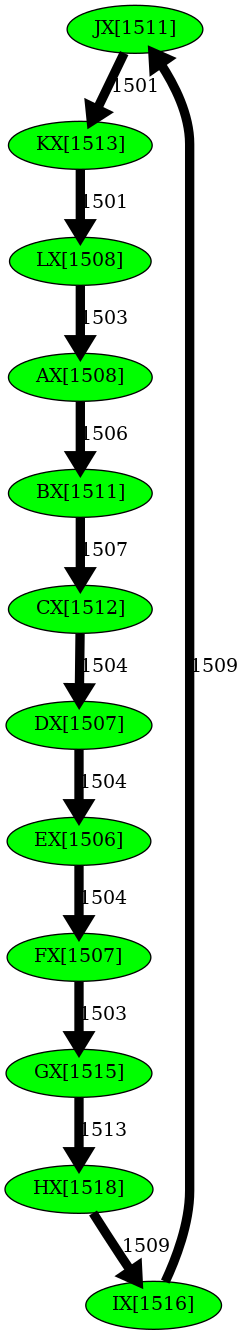

In [38]:
for c in cens:
    display(Image(filename=os.path.join(PATH, "PaperResults", "cen" + c, "simplified_graph", "graph.png")))